# Natural Language Processing Lab
#### Sentiment Analysis, and Named Entity Recognition

In [13]:
# Import necessary libraries
#!pip install nltk
import os
import nltk
import requests
import zipfile
import tarfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import (
    MarianMTModel, MarianTokenizer, pipeline,
    AutoModelForSequenceClassification, AutoTokenizer
)
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
import time
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)




# Named Entity Recognition (NER)

This notebook explores Named Entity Recognition (NER) using two approaches:

Named Entity Recognition (NER), an essential task in Natural Language Processing (NLP) used to identify and classify entities such as persons (PER), locations (LOC), organizations (ORG), and miscellaneous (MISC) entities in text. The notebook implements two distinct approaches for performing NER:

1. spaCy's Pre-trained Model – A fast, efficient, and ready-to-use NLP model for entity extraction.
2. Custom Deep Learning Model – A trainable NER system using LSTMs/BERT on the CoNLL-2003 dataset.

## Dataset Download

In [14]:
# Download CoNLL-2003
def download_conll2003():
    url = "https://data.deepai.org/conll2003.zip"
    response = requests.get(url)
    with open("conll2003.zip", "wb") as f:
        f.write(response.content)
    with zipfile.ZipFile("conll2003.zip", "r") as zip_ref:
        zip_ref.extractall("conll2003")
    os.remove("conll2003.zip")


download_conll2003()

# Load dataset


def load_conll2003():
    with open("conll2003/train.txt", "r", encoding="utf-8") as f:
        lines = f.readlines()
    sentences, tags = [], []
    current_sentence, current_tags = [], []
    for line in lines:
        if line.strip() == "":
            if current_sentence:
                sentences.append(current_sentence)
                tags.append(current_tags)
                current_sentence, current_tags = [], []
        else:
            parts = line.strip().split()
            current_sentence.append(parts[0])
            current_tags.append(parts[-1])
    return sentences[:500], tags[:500]


sentences, tags = load_conll2003()

## Pre-made Tool spaCy

spaCy is a fast and efficient Natural Language Processing (NLP) library designed for production use. It provides pre-trained models for tasks like Named Entity Recognition (NER), Part-of-Speech (POS) tagging, dependency parsing, and text classification


## predict_tags function (To Be Done)

In the predict_tags function, we aim to apply a pre-trained spaCy model to a given sentence (list of words)
and return a list of predicted labels (tags) for each word. Here's how it works step by step:

1. **Combine the Words into a Single String:**
Since sentence is a list of words, we join them with a space to create one string. This string is then fed into spaCy for processing.

2. **Initialize All Predictions as "O":**
We make a new list, predictions, the same length as sentence, and fill it with "O". This indicates that, by default, each word has no entity label.

3. **Check Each Recognized Entity:**
spaCy’s doc.ents provides a list of entities it finds. We loop through these entities.

4. **Match Each Word Against the Entity Text:**
For each entity, we check each word in our original sentence. If the word is part of the entity’s text (ent.text), we replace the "O" in predictions with the entity label (ent.label_).

5. **Return the Predictions:**
Finally, the function returns predictions, which is now a list of the same length as sentence, containing either "O" or the recognized entity label for each word.

In [15]:
# Preload spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to predict tags using spaCy
def predict_tags(sentence):

    #TODO code here
    sentence_str = " ".join(sentence)
    model = nlp(sentence_str)
    predictions = ["O"] * len(sentence)
    for ent in model.ents:
      ent_words = ent.text.split()
      for i in range(len(sentence) - len(ent_words) + 1):
        if sentence[i:i + len(ent_words)] == ent_words:
          for j in range(len(ent_words)):
            predictions[i + j] = ent.label_
    return predictions

    raise NotImplementedError

In [16]:
# Function to display random samples
def display_random_examples(sentences, tags, num_examples=5):
    print(f"Displaying {num_examples} random examples with actual and predicted tags:\n")
    random_indices = random.sample(range(len(sentences)), num_examples)  # Select random indices
    for i in random_indices:
        print(f"Example {i + 1}:")
        print("Full Sentence: ", " ".join(sentences[i]))
        print("\nBreakdown:")
        predicted_tags = predict_tags(sentences[i])
        print("Word\t\tActual Tag\tPredicted Tag")
        print("-" * 40)
        for word, actual_tag, predicted_tag in zip(sentences[i], tags[i], predicted_tags):
            print(f"{word}\t\t{actual_tag}\t\t{predicted_tag}")
        print("\n" + "-" * 50 + "\n")  # Separator between examples

# Display 5 random examples
display_random_examples(sentences, tags, num_examples=5)

Displaying 5 random examples with actual and predicted tags:

Example 189:
Full Sentence:  " The embassy is issuing them travel documents for their return to their homeland .

Breakdown:
Word		Actual Tag	Predicted Tag
----------------------------------------
"		O		O
The		O		O
embassy		O		O
is		O		O
issuing		O		O
them		O		O
travel		O		O
documents		O		O
for		O		O
their		O		O
return		O		O
to		O		O
their		O		O
homeland		O		O
.		O		O

--------------------------------------------------

Example 32:
Full Sentence:  China says Taiwan spoils atmosphere for talks .

Breakdown:
Word		Actual Tag	Predicted Tag
----------------------------------------
China		B-LOC		GPE
says		O		O
Taiwan		B-LOC		GPE
spoils		O		O
atmosphere		O		O
for		O		O
talks		O		O
.		O		O

--------------------------------------------------

Example 435:
Full Sentence:  Martin Damm ( Czech Republic ) beat 6 - Younes El Aynaoui

Breakdown:
Word		Actual Tag	Predicted Tag
----------------------------------------
Martin		B-PER		PERSON


## Low Level Implementation

### Data Preprocessing


In [17]:
# Function to preprocess data (removes special characters)
def preprocess_data(sentences, tags):
    regex = re.compile(r'[^a-zA-Z\s]')  # Matches non-alphabetic characters
    adjusted_sentences = []
    adjusted_tags = []

    for sentence, tag_sequence in zip(sentences, tags):
        adjusted_sentence = []
        adjusted_tag_sequence = []
        for word, tag in zip(sentence, tag_sequence):
            cleaned_word = re.sub(regex, '', word)  # Remove special characters
            if cleaned_word:  # Only keep non-empty words
                adjusted_sentence.append(cleaned_word)
                adjusted_tag_sequence.append(tag)
        adjusted_sentences.append(adjusted_sentence)
        adjusted_tags.append(adjusted_tag_sequence)

    return adjusted_sentences, adjusted_tags

For the prepare_data function: (To Be Done)
------------
This function takes in tokenized sentences and their corresponding tag sequences
(e.g., "O", "PERSON", "ORG", etc.) and encodes them into numeric values so
they can be used by machine learning models.

1. **Initialize the Encoders:**
   - Create one `LabelEncoder` for words (named `word_encoder`).
   - Create another `LabelEncoder` for tags (named `tag_encoder`).

2. **Flatten the Data for Fitting:**
   - Since each sentence is a list of words and each tag sequence is a list of tags, first flatten these lists into single lists.
     - For words: Create a list of all words from all sentences.
     - For tags: Create a list of all tags from all tag sequences.

3. **Fit the Encoders:**
   - Fit `word_encoder` on the flattened list of words.
   - Fit `tag_encoder` on the flattened list of tags.

4. **Encode the Data:**
   - Convert each sentence into a list of integers by transforming every word using `word_encoder`.
   - Do the same for the tags: convert each tag sequence into a list of integers using `tag_encoder`.

5. **Return the Encoded Data and Encoders:**
   - The function should return the encoded sentences (`X`), encoded tags (`y`), and both encoders (`word_encoder` and `tag_encoder`).

In [18]:

# Function to prepare data for training
def prepare_data(sentences, tags):
    #TODO code here
    # Initialize label encoders for words and tags
    word_encoder = LabelEncoder()
    tag_encoder = LabelEncoder()
    # Flatten sentences and tags for fitting
    flat_sentences = [word for sentence in sentences for word in sentence]
    flat_tags = [tag for tag_seq in tags for tag in tag_seq]
    # Fit label encoders
    word_encoder.fit(flat_sentences)
    tag_encoder.fit(flat_tags)
    # Convert sentences and tags into encoded format
    X = [[word_encoder.transform([word])[0] for word in sentence] for sentence in sentences]
    y = [[tag_encoder.transform([tag])[0] for tag in tag_seq] for tag_seq in tags]
    return X, y, word_encoder, tag_encoder
    raise NotImplementedError


# Function to calculate sample weights
def calculate_sample_weights(y_true, class_weight_dict):
    sample_weights = np.ones(y_true.shape)
    for i, seq in enumerate(y_true):
        for j, label in enumerate(seq):
            if label != 0:  # Ignore padding tokens (usually represented as 0)
                sample_weights[i, j] = class_weight_dict[label]
    return sample_weights

## Data Preparation for training (To Be Done)

You just have to pre-process the data and then pass that to prepare function. The output from prepare function is used below, so name the variables according to the return statement given in the prepare_data function

In [19]:
#TODO code here
# Preprocess data (use the above preprocess_data function)
sentences, tags = preprocess_data(sentences, tags)


# Prepare data for training (use the above prepare_date function. This takes in pre-processed inputs).
X, y, word_encoder, tag_encoder = prepare_data(sentences, tags)


# Get the index for the "O" tag
o_tag_index = tag_encoder.transform(["O"])[0]

# Pad sequences to ensure consistent input length
max_len = max(len(sentence) for sentence in X)
X_padded = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
y_padded = pad_sequences(y, maxlen=max_len, padding='post', truncating='post', value=o_tag_index)

# Compute class weights to handle imbalanced data
flattened_y_train = np.concatenate(y_padded)
class_weights = compute_class_weight('balanced', classes=np.unique(flattened_y_train), y=flattened_y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

### Model Definition (To Be Done)

See the picture below and the model code from the In-Class lab for help and implement the middle layers as the input and output layers are provided.

1. **Bidirectional LSTM Layer: (2nd Layer)**  
   - An LSTM (Long Short-Term Memory) layer that processes sequences from both directions. Use `return_sequences=True` as it ensures the layer outputs a sequence, which is necessary for sequence labeling tasks like NER.

2. **Dropout Layer:**  
   - A dropout rate of 0.1 is applied to help prevent overfitting.

3. **Dense Layer:**  
   - A fully-connected layer with 64 units and a ReLU activation function, serving as an intermediate layer.

![sentiment_model_lr.png](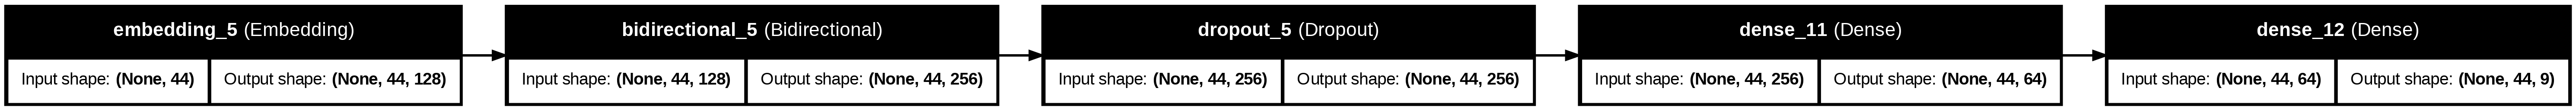
)

In [20]:
# Create the NER model using LSTM
def create_ner_model(vocab_size, num_tags, max_len):
    model = tf.keras.Sequential([
        #TODO code here
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True, recurrent_dropout=0.1)),
        tf.keras.layers.Dropout(rate = 0.1),
        #middle layers
        tf.keras.layers.Dense(units = 64, activation = 'relu'),
        tf.keras.layers.Dense(num_tags, activation='softmax')  # Softmax for class probabilities
    ])


    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the NER model
ner_model = create_ner_model(len(word_encoder.classes_), len(tag_encoder.classes_), max_len)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Training the Model

In [21]:
# Calculate sample weights
sample_weights = calculate_sample_weights(y_padded, class_weight_dict)

# Train the model using sample weights
history = ner_model.fit(
    X_padded,
    np.expand_dims(y_padded, -1),
    sample_weight=sample_weights,
    batch_size=32,
    epochs=15,
    validation_split=0.2,
)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.4456 - loss: 2.0572 - val_accuracy: 0.8673 - val_loss: 1.7987
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.7145 - loss: 1.8132 - val_accuracy: 0.8661 - val_loss: 1.6906
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.7215 - loss: 1.6397 - val_accuracy: 0.8714 - val_loss: 1.6028
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.7500 - loss: 1.4775 - val_accuracy: 0.8707 - val_loss: 1.5847
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.7320 - loss: 1.4857 - val_accuracy: 0.8800 - val_loss: 1.5591
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.7626 - loss: 1.0987 - val_accuracy: 0.8745 - val_loss: 1.5759
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.7588 - loss: 1.0206 - val_accuracy: 0.8786 - val_loss: 1.5383
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.7712 - loss: 0.7882 - val_accuracy: 0

### Evaluation and Prediction

In [22]:
# Evaluate the model
loss, accuracy = ner_model.evaluate(X_padded, np.expand_dims(y_padded, -1))
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Make predictions
predictions = ner_model.predict(X_padded)

# Convert predictions back to tag labels
predicted_tags = [tag_encoder.inverse_transform(np.argmax(pred, axis=-1)) for pred in predictions]

# Display example predictions
for i in range(5):  # Display 5 random predictions
    print(f"Sentence: {' '.join([word_encoder.inverse_transform([word])[0] for word in X_padded[i]])}")
    print(f"True Tags: {tag_encoder.inverse_transform(y_padded[i])}")
    print(f"Predicted Tags: {predicted_tags[i]}")
    print("-" * 50)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8939 - loss: 0.3198
Test Loss: 0.2853, Test Accuracy: 0.9055
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Sentence: DOCSTART A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A
True Tags: ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
Predicted Tags: ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
--------------------------------------------------
Sentence: EU rejects German call to boycott British lamb A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A
True Tags: ['B-ORG' 'O' 'B-MISC' 'O' 'O' 'O' 'B-MISC' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' '

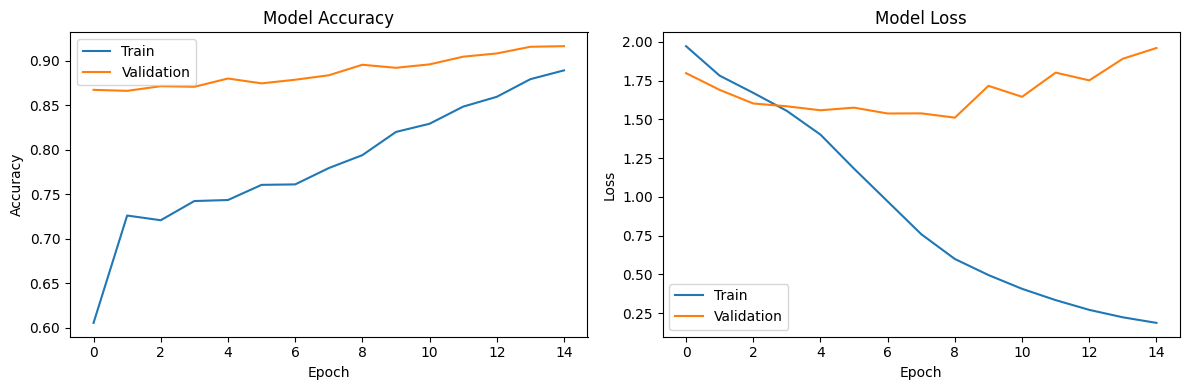

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

## Analysis: Accuracy Comparison of Pre-made Tools and Custom Implementation

spaCy gives quick results and is easy to use, but it might miss some details.
The custom model needs training but can understand the data better.
Custom models are often more accurate, but spaCy saves time.
accuracy: 0.8939 - loss: 0.3198
Test Loss: 0.2853, Test Accuracy: 0.9055